In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
geno = pd.read_csv('../alphasimr/WF_Ne100k_samples_10k_H2_05_qtl_10k_corA_02_25traits_g.txt', index_col=0, sep=" ")
pheno = pd.read_csv('../alphasimr/WF_Ne100k_samples_10k_H2_05_qtl_10k_corA_02_25traits_p.txt', index_col=0, sep=" ")
eff = pd.read_csv('../alphasimr/WF_Ne100k_samples_10k_H2_05_qtl_10k_corA_02_25traits_eff.txt', index_col=0, sep=" ")


In [3]:
Z = geno.T.values
y = pheno.iloc[:, 1].values


In [4]:
# Step 3: Train/Test Split (First 90% for training)
n_samples = Z.shape[0]
split_index = int(n_samples * 0.9)  # 90% of samples

Z_train, Z_test = Z[:split_index, :], Z[split_index:, :]
y_train, y_test = y[:split_index], y[split_index:]

In [5]:
# Compute mean allele frequency for each SNP
p = np.mean(Z_train, axis=0)

# Mean-center genotype matrices
Z_train_centered = Z_train - p
Z_test_centered = Z_test - p

In [6]:
h2 = 0.5  # Example narrow-sense heritability
lambda_rrblup = (1 - h2) / h2  # Equivalent ridge penalty


In [10]:
ridge_model = Ridge(alpha=lambda_rrblup)
ridge_model.fit(Z_train_centered, y_train)


Ridge()

In [11]:
beta_hat = ridge_model.coef_
u_hat = Z_test_centered @ beta_hat


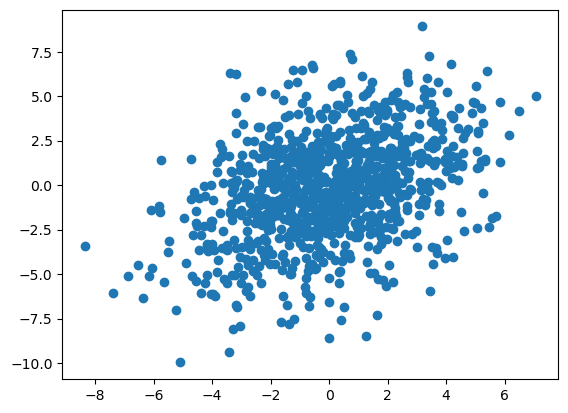

In [12]:
plt.scatter(y_test,u_hat)

In [13]:
from scipy import stats
stats.pearsonr(y_test,u_hat)

PearsonRResult(statistic=0.3781452132214397, pvalue=2.4045826716384977e-35)